In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy
import matplotlib.pyplot as plt

In [3]:
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/Stuart_bm/Stuart_bmcite_RNAassay_original.h5ad')
adata = sc.read_h5ad(dataset_dir / 'Stuart_bm/Stuart_bmcite_RNAassay_original.h5ad')
adata.shape

(30672, 17009)

In [4]:
adata.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508


In [5]:
adata.obs['celltype.l1'].value_counts()

celltype.l1
T cell              14901
Mono/DC              7729
B cell               3753
Progenitor cells     2879
NK                   1410
Name: count, dtype: int64

In [6]:
adata.obs['celltype.l2'].value_counts()

celltype.l2
CD14 Mono         6486
CD4 Naive         4500
CD8 Naive         3974
CD4 Memory        3360
Naive B           1900
Memory B          1630
NK                1267
Prog_RBC           915
GMP                748
CD8 Effector_1     577
CD8 Memory_2       555
MAIT               520
cDC2               482
CD8 Memory_1       444
CD16 Mono          433
gdT                367
pDC                328
CD8 Effector_2     307
Treg               297
LMPP               292
HSC                263
Prog_DC            263
Plasmablast        223
Prog_B 1           145
CD56 bright NK     143
Prog_B 2           129
Prog_Mk            124
Name: count, dtype: int64

## Plot cell number pie chart

In [7]:
# Get colors from Hao PBMC
# hao = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
hao = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
l1_colors_hao = hao.uns['celltype.l1_colors']  # in celltype alphabet order
l2_colors_hao = hao.uns['celltype.l2_colors']

In [8]:
# Get cell counts for each cell type
l1_cell_counts = adata.obs['celltype.l1'].value_counts()  # in value order 
l2_cell_counts = adata.obs['celltype.l2'].value_counts()

# Colors: from Hao colors
l1_colors = l1_colors_hao[:len(l1_cell_counts)]
l2_colors = l2_colors_hao[:len(l2_cell_counts)]
# map cell type names to colors
l1_cmap = dict(zip(l1_cell_counts.index.sort_values(), l1_colors))  # in alphabet order
l2_cmap = dict(zip(l2_cell_counts.index.sort_values(), l2_colors))

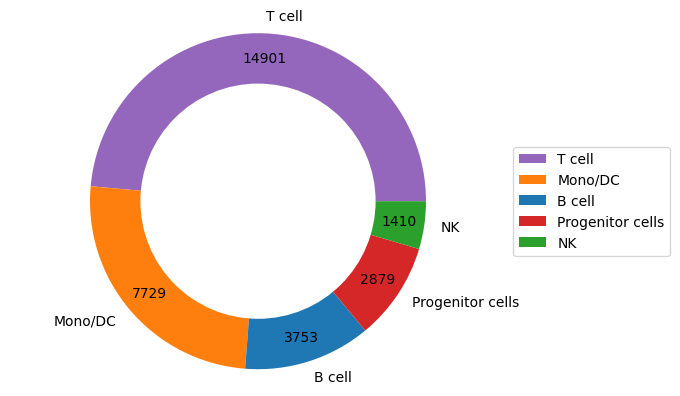

In [9]:
# Function: input percentage, output absolute count
def absolute_value(val):
    a = round(val/100.*l1_cell_counts.sum())
    return f"{a:d}"

# Plot pie chart with actual cell counts
color_list = [l1_cmap[celltype] for celltype in l1_cell_counts.index]
plt.pie(l1_cell_counts, labels=l1_cell_counts.index, colors=color_list, autopct=absolute_value, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Move legend to the right side of the chart
plt.legend(l1_cell_counts.index.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

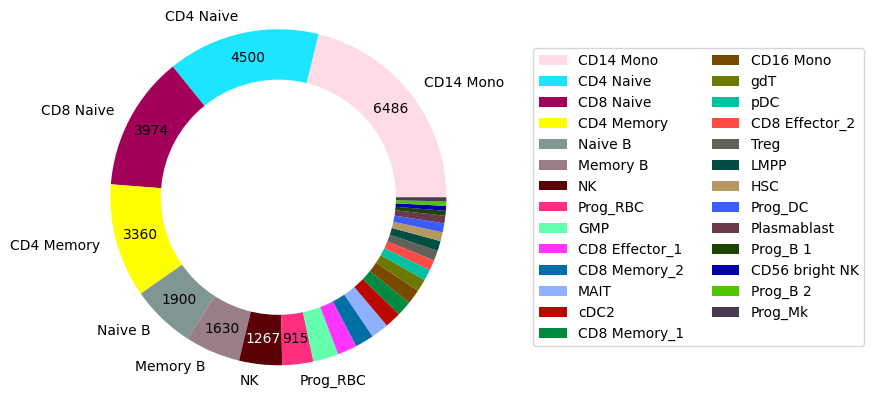

In [10]:
import matplotlib.pyplot as plt

# Get the top 8 cell types
top_8_types = l2_cell_counts.index[:8]

# Define a custom autopct function
def custom_autopct(pct, all_vals):
    total = sum(all_vals)
    count = int(round(pct * total / 100.0))
    return f"{count}" if l2_cell_counts[l2_cell_counts == count].index[0] in top_8_types else ""

    

# Plot pie chart
color_list = [l2_cmap[celltype] for celltype in l2_cell_counts.index]
top_8_labels = l2_cell_counts.index.tolist()[:8] + [' ']*19
wedges, texts, autotexts = plt.pie(
    l2_cell_counts,
    colors=color_list,
    labels=top_8_labels,
    autopct=lambda pct: custom_autopct(pct, l2_cell_counts),
    pctdistance=0.85
)

# Customize the text color for NK count
for i, text in enumerate(autotexts):
    if top_8_labels[i] == "NK":
        text.set_color("white")

# Draw a circle at the center of the pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis("equal")

# Move legend to the right side of the chart
plt.legend(
    l2_cell_counts.index.tolist(), loc="center left", bbox_to_anchor=(1, 0.5), ncol=2
)

# Show the plot
plt.show()
